# Polygon around data area

Related to the [Create a polygon with real data extents](https://github.com/agile-geoscience/seisplot/issues/27) issue.

Plan:

1. Make some data.
2. Condition the data into a binary cube.
3. Make a contour around the data area.

## Make some data with lots of nulls

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

There's already a small 3D in the `data` directory...

In [2]:
ls data

31_81_PR.png       31_81_PR.sgy       F3_very_small.png  F3_very_small.sgy


In [3]:
from obspy.segy.segy import readSEGY
section = readSEGY('data/F3_very_small.sgy', unpack_headers=True)
data = np.vstack([t.data for t in section.traces]).T
data.shape

(463, 121)

In [4]:
cube = np.reshape(data.T, (11, 11, 463))

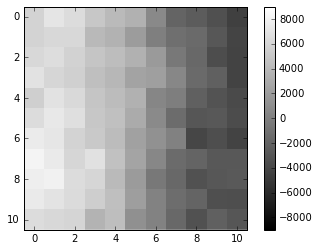

In [5]:
plt.imshow(cube[:,:,200], interpolation='none', cmap="gray", vmin=-9000, vmax=9000)
plt.colorbar()
plt.show()

In [6]:
d = np.hstack([0*cube, cube, 0*cube])

In [7]:
cube = np.vstack([0*d, d, 0*d])

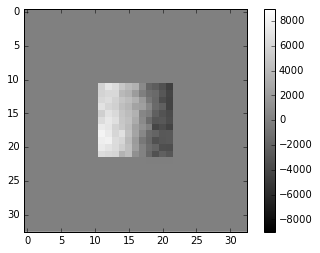

In [8]:
plt.imshow(cube[:,:,200], interpolation='none', cmap="gray", vmin=-9000, vmax=9000)
plt.colorbar()
plt.show()

## Condition the data

First we need to make a binary volume, with 1 where there's live data, 0 where there's only null traces. 

We can do stuff trace by trace and avoid affecting the null data.

In [9]:
all_positive = np.abs(cube)

# Make sure we add enough to ensure a positive number.
all_gt_zero = all_positive[...,:-2] + all_positive[...,1:-1] + all_positive[...,1:-1] + all_positive[...,2:]

flag = np.digitize(all_gt_zero, [0], right=True)

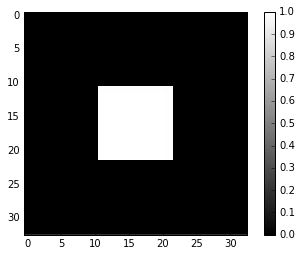

In [10]:
plt.imshow(flag[:,:,200], interpolation='none', cmap="gray")
plt.colorbar()
plt.show()

In [11]:
tslice = flag[:, :, flag.shape[-1]//2]

In [12]:
tslice.shape

(33, 33)

## Contours on image

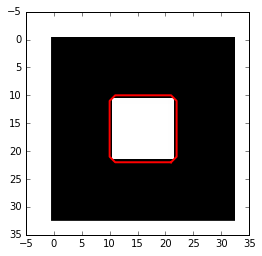

In [13]:
from skimage import measure

# Find contours at a constant value of 0
contours = measure.find_contours(tslice, 0)

# Display the image and plot all contours found
plt.imshow(tslice, interpolation='none', cmap='gray')

for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')

plt.show()

## `shapely` convex hull

In [14]:
from shapely.geometry import MultiPoint

In [15]:
points = np.array(list(zip(*np.where(tslice == 1))))

In [16]:
mp = MultiPoint(points)

In [17]:
hull = mp.convex_hull

# Optionally buffer the polygon.
hull = hull.buffer(0.5)

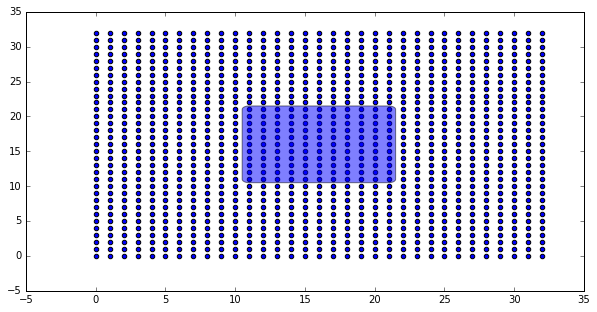

In [18]:
from descartes import PolygonPatch

# Compute all points coordinates for the plot.
all_points = np.array(list(zip(*np.where(tslice < 2))))

# Make the plot.
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(all_points[:,0], all_points[:,1])

# Make and add the polygon patch.
patch = PolygonPatch(hull, alpha=0.5)
ax.add_patch(patch)

plt.show()